In [8]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Loading the dataset

In [9]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path, low_memory = False)

In [10]:
data.head()

,Unnamed: 0,year,round,from_country,to_country,total_points,tele_points,jury_points,Year_from,iso-alpha-3_from,...,city_to,lat_to,lon_to,GDP per capita (current US$)_to,"Population, total_to",distance,jaccard_artists,jaccard_genre,dice_genre,dice_artists
0,0,1960,final,at,fr,1,NaN,NaN,1960,AUT,...,Paris,3.760847e+06,2.889644e+06,1302.53149729892,47412964,1036.040752,0.153846,0.090909,0.166667,0.266667
1,1,1960,final,at,gb,3,NaN,NaN,1960,AUT,...,London,3.620981e+06,3.203213e+06,1397.5948032844,52400000,1237.492544,0.302326,0.224490,0.366667,0.464286
2,2,1960,final,at,mc,0,NaN,NaN,1960,AUT,...,Monaco,4.111648e+06,2.295892e+06,..,21808,852.872041,0.111111,0.200000,0.333333,0.200000
3,3,1960,final,at,no,1,NaN,NaN,1960,AUT,...,Oslo,4.362948e+06,4.091117e+06,1451.2850779894,3581239,1353.489212,0.292683,0.200000,0.333333,0.452830
4,4,1960,final,at,de,2,NaN,NaN,1960,AUT,...,Berlin,4.551651e+06,3.273670e+06,1162.12266831735,72814900,524.812724,0.666667,0.666667,0.800000,0.800000


## Preprocessing the dataset

In [11]:
# IMPORTANT: No Australia, Morocco and only Grand Final jury votes, so year >= 2016

data2 = data[(data["from_country"] != "au") & (data["to_country"] != "au") & (data["round"] == "final") & (data["from_country"] != "ma") & (data["to_country"] != "ma") & (data["year"] >= 2016)].copy()

columns_to_use = ["from_country", "to_country", "jury_points", "distance","GDP per capita (current US$)_from", "GDP per capita (current US$)_to", "dice_genre", "dice_artists"]
data2.replace("..",float("nan"),inplace=True)
filtered_data = data2[columns_to_use].dropna()

filtered_data["GDP per capita (current US$)_from"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_from"], errors="coerce")
filtered_data["GDP per capita (current US$)_to"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_to"], errors="coerce")
filtered_data["GDP_Difference"] = filtered_data["GDP per capita (current US$)_from"] - filtered_data["GDP per capita (current US$)_to"]

filtered_data["distance_normalized"] = (    # Normalize distance
    filtered_data["distance"] - filtered_data["distance"].mean()
) / filtered_data["distance"].std()

columns_to_use = ["from_country", "to_country", "jury_points", "distance", "distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]
filtered_data = filtered_data[columns_to_use]

aggregated_data = filtered_data.groupby(["from_country", "to_country"], as_index = False).agg({
    "jury_points": "mean",     # Average points awarded
    "distance": "mean",          # Distance
    "distance_normalized": "mean",
    "GDP_Difference": "mean",
    "dice_genre" : "mean",
    "dice_artists": "mean"
})

aggregated_data["GDP_Difference"] = (     # Normalize GDP
    aggregated_data["GDP_Difference"] - aggregated_data["GDP_Difference"].mean()
) / aggregated_data["GDP_Difference"].std()

aggregated_data



,from_country,to_country,jury_points,distance,distance_normalized,GDP_Difference,dice_genre,dice_artists
0,al,am,5.250000,2073.730122,0.388484,0.038212,1.000000,1.000000
1,al,at,0.000000,808.975149,-0.977360,-1.293316,0.333333,0.200000
2,al,az,3.000000,2507.648698,0.857085,0.031009,1.000000,1.000000
3,al,be,1.400000,1589.695421,-0.134238,-1.242663,0.333333,0.266667
4,al,bg,5.500000,328.355601,-1.496395,-0.105329,0.200000,0.313725
...,...,...,...,...,...,...,...,...
1694,ua,rs,0.000000,981.120607,-0.791456,-0.133478,0.233333,0.687500
1695,ua,ru,0.000000,760.610235,-1.029591,-0.189213,0.100000,0.260870
1696,ua,se,4.333333,1269.957029,-0.479533,-1.512311,0.200000,0.200000
1697,ua,si,4.000000,1280.992967,-0.467615,-0.726826,0.200000,0.375000


,jury_points,distance,GDP_Difference,dice_genre,dice_artists
jury_points,1.000000,-0.085826,-0.032652,0.074608,0.094488
distance,-0.085826,1.000000,0.003478,-0.012600,-0.146507
GDP_Difference,-0.032652,0.003478,1.000000,-0.011309,0.004135
dice_genre,0.074608,-0.012600,-0.011309,1.000000,0.650465
dice_artists,0.094488,-0.146507,0.004135,0.650465,1.000000


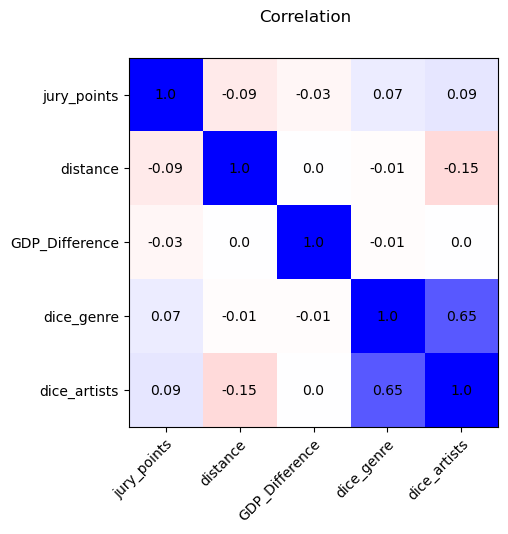

In [12]:
def plot_correlation(aggregated_data):
    corr = aggregated_data.drop(["to_country", "from_country", "distance_normalized"], axis=1).corr()

    fig, ax = plt.subplots()
    im = ax.imshow(corr, cmap="bwr_r", vmin=-1, vmax=1)
    # ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(range(corr.shape[0]), labels=corr.columns,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(corr.shape[1]), labels=corr.columns)
    corr_np = np.round(corr.to_numpy(), 2)
    for i, row in enumerate(corr_np):
        for j, val in enumerate(row):
            text = ax.text(j, i, val,
                        ha="center", va="center", color="black")
    # ax.tick_params(top=True, bottom=False,
    #                    labeltop=True, labelbottom=False)
    fig.suptitle("Correlation")
    plt.savefig("../plots/data/jury_correlation.png", bbox_inches='tight')
    return corr

plot_correlation(aggregated_data)

## Overall Linear Regression for distance

First, we want to investigate whether the overall distance between the capitals of voting and receiving countries has a significant impact on the average points awarded in the Grand Final over the years.

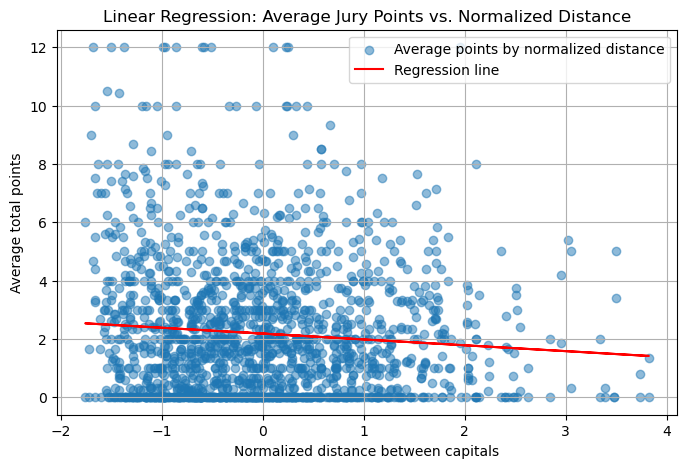

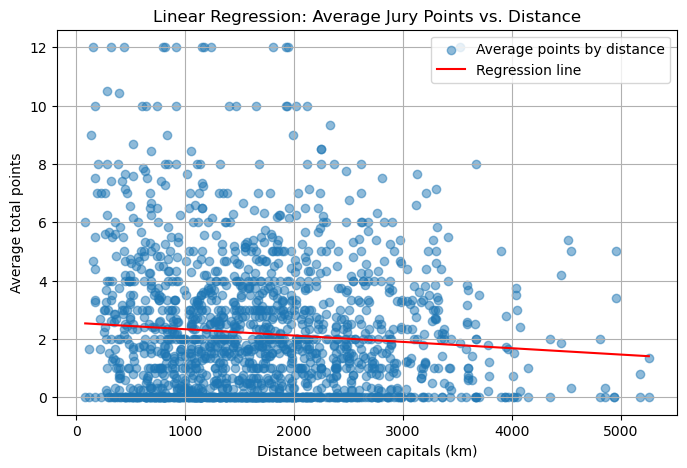

                            OLS Regression Results                            
Dep. Variable:            jury_points   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     12.59
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           0.000398
Time:                        20:23:21   Log-Likelihood:                -3834.1
No. Observations:                1699   AIC:                             7672.
Df Residuals:                    1697   BIC:                             7683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.1811    

In [13]:
X_agg = sm.add_constant(aggregated_data["distance_normalized"])
Y_agg = aggregated_data["jury_points"]

agg_model = sm.OLS(Y_agg, X_agg).fit()      # Ordinary Least Squares for Linear Regression
agg_summary = agg_model.summary()

distance_mean = aggregated_data["distance"].mean()      # Unnormalized distance predictions back to original scale for plotting
distance_std = aggregated_data["distance"].std()
x_plot_original = np.linspace(aggregated_data["distance"].min(), aggregated_data["distance"].max(), 100)        
x_plot_normalized = (x_plot_original - distance_mean) / distance_std
x_plot_with_const = sm.add_constant(x_plot_normalized)
y_plot = agg_model.predict(x_plot_with_const)

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance_normalized"], aggregated_data["jury_points"], alpha=0.5, label="Average points by normalized distance")
plt.plot(aggregated_data["distance_normalized"], agg_model.predict(X_agg), color="red", label="Regression line")
plt.title("Linear Regression: Average Jury Points vs. Normalized Distance")
plt.xlabel("Normalized distance between capitals")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall_normalized_jury.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance"], aggregated_data["jury_points"], alpha=0.5, label="Average points by distance")
plt.plot(x_plot_original, y_plot, color="red", label="Regression line")
plt.title("Linear Regression: Average Jury Points vs. Distance")
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall_jury.png")
plt.show()

print(agg_summary)


### Results explanation

· R²: 0.007 → Only 0.7% of the variance in the average points awarded can be explained by the distance, so distance is not a strong predictor of the overall voting behavior.

· Prob (F-statistic): 3.98e-4 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that distance should have some effect on Eurovision voting, but very small.

· Coefficients:

- Intercept (const): 2.1811 → Represents the predicted average points a country at an average distance from another country would receive.

- Distance Coefficient (normalized): -0.2003 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount.

- p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely to be due to random chance).

### Conclusion

Though statistically significant, this effect is very small in magnitude, suggesting that distance only slightly reduces the points awarded.

While distance has a small but significant negative impact on points awarded, the low R² suggests that other factors (such as cultural, political, and historical ties) likely play a much larger role

## Overall Linear Regression with multiple factor (distance, GDP, music preferences)

Fist, we have to select and normalize the data we are going to use:

### Regression with distance

In [14]:
X_full = aggregated_data[["distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]]
X_full = sm.add_constant(X_full)
Y = aggregated_data["jury_points"]

model_full = sm.OLS(Y, X_full).fit()
print("Regression including distance:\n", model_full.summary())

Regression including distance:
                             OLS Regression Results                            
Dep. Variable:            jury_points   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     6.848
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.82e-05
Time:                        20:23:22   Log-Likelihood:                -3826.8
No. Observations:                1699   AIC:                             7664.
Df Residuals:                    1694   BIC:                             7691.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
co

### Results Explanation

· R²: 0.016 → Only 1.6% of the variance in the average points awarded can be explained by the independent variables, meaning that distance, GDP difference, and music similarity do not strongly predict voting behavior in Eurovision.

· Prob (F-statistic): 1.82e-05 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that at least one of the predictors has an effect on Eurovision voting, even if the explanatory power is weak.

· Coefficients:

- Intercept (const): 1.8196 → Represents the predicted average points a country receives at an average distance, GDP difference, and music similarity.

- Distance Coefficient: -0.1778 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount.
- Distance p-value (P>|t|): 0.002 → The effect of distance is highly statistically significant (unlikely due to random chance).

- GDP Difference Coefficient: -0.0749 → For every 1-standard deviation increase in distance, the expected number of points also decreases by that amount.
- GDP difference p-value (P>|t|): 0.181 → This variable is not statistically significant, meaning GDP difference does not influence Eurovision jury voting behavior.

- Dice Genre Coefficient: 0.3959 → A higher similarity in music genres leads to slightly more points being awarded.
- Genres preference p-value (P>|t|): 0.303 → This variable is not statistically significant, meaning genre similarity does not impact Eurovision jury voting behavior.

- Dice Artists Coefficient: 0.7514 → A higher similarity in music artists leads to more points being awarded.
- Artists preference p-value (P>|t|): 0.055 → This effect is now not statistically significant, meaning countries with similar top artists not impact Eurovision jury voting behavior.

### Conclusion

While distance has a moderate and statistically significant negative impact, its effect remains limited, as shown by the still low R² value.

Other factors are now not statistically significant.

This suggests that Eurovision jury voting is influenced more by distance than by cultural and musical connections.

However, the low R² value indicates that many other factors (such as historical alliances, politics, language, and diaspora voting) likely play a much larger role.



### Regression without distance

Now we are going to rerun the regression without distance to determine how much influence distance had on the model.

If removing distance significantly changes the coefficients, p-values, or R², it would suggest that distance was a key predictor. If nothing changes much, then distance was not contributing significantly to explaining the variation in voting behavior.

In [15]:
X_no_distance = aggregated_data[["GDP_Difference", "dice_genre", "dice_artists"]]
X_no_distance = sm.add_constant(X_no_distance)

model_no_distance = sm.OLS(Y, X_no_distance).fit()
print("\nRegression without distance:\n", model_no_distance.summary())


Regression without distance:
                             OLS Regression Results                            
Dep. Variable:            jury_points   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.879
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           0.000544
Time:                        20:23:22   Log-Likelihood:                -3831.6
No. Observations:                1699   AIC:                             7671.
Df Residuals:                    1695   BIC:                             7693.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

In [16]:
model_full.compare_f_test(model_no_distance)

(9.66427449729099, 0.001910114039576976, 1.0)

### Results Comparison

· R² decreased: (from 0.016 to 0.010) → When distance was removed, the model's explanatory power dropped significantly. This indicates that distance had a notable effect on predicting voting behavior, but it is still weak.

· All other factors are still not significact, except the artist similarity. 
- Artists coefficient increased: (from 0.7514 to 0.9729) → Artist similarity became influential when distance was removed, suggesting that distance and artist similarity were correlated. Countries close to each other not only vote for each other due to proximity but also because they share music artists.

### Analysis of the residuals distribution plot

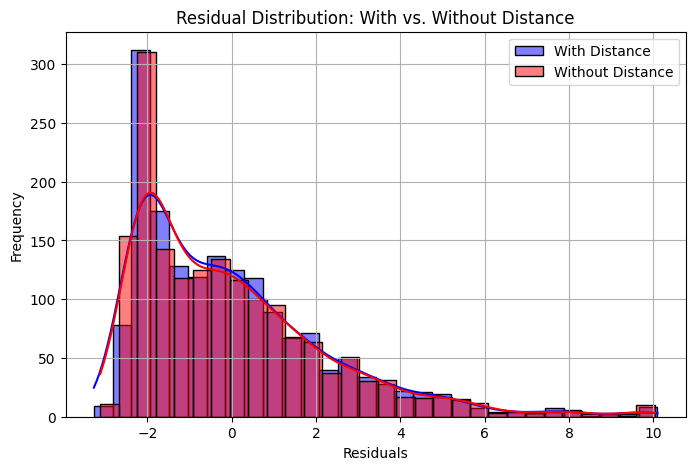

In [8]:
residuals_full = model_full.resid
residuals_no_distance = model_no_distance.resid

plt.figure(figsize=(8, 5))
sns.histplot(residuals_full, bins=30, color="blue", alpha=0.5, label="With Distance", kde=True)
sns.histplot(residuals_no_distance, bins=30, color="red", alpha=0.5, label="Without Distance", kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution: With vs. Without Distance")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/residuals_jury.png")
plt.show()

· General shape and distribution:

- The residuals show a right-skewed distribution, meaning the model underpredicts points more often than it overpredicts.

- The majority of residuals are clustered between -2.5 and 2.5, with a peak slightly below 0, indicating that the model's predictions are generally close to actual values but slightly underestimated.

- The long right tail suggests that there are cases where the model fails to capture extreme scores, possibly due to outliers such as politically or culturally aligned countries that award each other more points than expected.

· Comparison: with vs. without distance:

- The blue curve (with distance) and red curve (without distance) are almost identical, meaning that removing distance does not significantly alter the model's error distribution.
- This reinforces the idea that distance is not a key explanatory variable in predicting Eurovision voting behavior.
- The fact that both distributions follow nearly the same trend suggests that other factors (such as artist similarity, genre similarity, or historical voting patterns) are playing a much bigger role.

· Implications for model performance:

- The wide spread of residuals indicates that the model is struggling to capture all the factors influencing voting, since many points awarded deviate significantly from the predictions.
- The right-skewness and extreme values suggest that external sociopolitical and cultural factors are likely influencing Eurovision voting—factors that are not captured by the variables in the model (distance, GDP, genre, and artist similarity).

# Linear Regression Country-wise using only distance (mean)

Fist, we need to obtain a list containing all the participat countries, so we can iterate over them:

In [9]:
participant_countries = filtered_data["from_country"].unique()
print(participant_countries)

['al' 'am' 'at' 'az' 'by' 'be' 'ba' 'bg' 'hr' 'cy' 'cz' 'dk' 'ee' 'fi'
 'fr' 'ge' 'de' 'gr' 'hu' 'is' 'ie' 'il' 'it' 'lv' 'lt' 'mt' 'md' 'me'
 'nl' 'mk' 'no' 'pl' 'ru' 'sm' 'rs' 'si' 'es' 'se' 'ch' 'ua' 'gb' 'pt'
 'ro']


Once obtained, we have to set the analysis that is going to be done to every country:

In [10]:
def analyze_country_data_only_distance(country_code):

    country_info_path = "../data/country_info.csv"
    country_info = pd.read_csv(country_info_path)

    country_row = country_info[country_info["code"].str.lower() == country_code.lower()]    # Map the country code to its corresponding country 
    if country_row.empty:
        print(f"Country {country_code} not found in the country information dataset.")
        return
    country_name = country_row["name"].values[0]

    country_data = aggregated_data[aggregated_data["from_country"] == country_code]
    X_agg = sm.add_constant(country_data["distance_normalized"])
    Y_agg = country_data["jury_points"]

    agg_model = sm.OLS(Y_agg, X_agg).fit()
    agg_summary = agg_model.summary()

    plt.figure(figsize=(8, 5))
    plt.scatter(country_data["distance_normalized"], country_data["jury_points"], alpha=0.5, label="Average points by normalized distance")
    plt.plot(country_data["distance_normalized"], agg_model.predict(X_agg), color="red", label="Regression line")
    plt.title(f"Linear Regression country-wise: Average Jury Points vs. Normalized Distance ({country_name} - {country_code})")
    plt.xlabel("Normalized distance between capitals")
    plt.ylabel("Average jury points")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"../plots/linear_regression/{country_name}_{country_code}_normalized_jury.png")
    #plt.show()
    plt.close()

    p_value = agg_model.pvalues["distance_normalized"]
    coefficient = agg_model.params["distance_normalized"]
    #print(agg_summary)

    return country_name, p_value, coefficient, agg_model.resid

We want to separate the countries into two lists: in one of them we will add the countries whose p-value is significant (applying Bonferroni COrrection) and in the other, those that do not, both being ordered from lowest to highest p-value.


Significant countries (p < 0.0011627906976744186):

Non-significant countries (p < 0.0011627906976744186):
Montenegro: p-value = 0.010906 - coefficient = -1.389439
Estonia: p-value = 0.018379 - coefficient = -0.937069
Greece: p-value = 0.049426 - coefficient = -0.964088
Iceland: p-value = 0.060534 - coefficient = -0.592832
Albania: p-value = 0.076186 - coefficient = -0.932260
North Macedonia: p-value = 0.114647 - coefficient = -0.535255
Malta: p-value = 0.118990 - coefficient = -0.618923
Poland: p-value = 0.134904 - coefficient = 0.697765
Israel: p-value = 0.141255 - coefficient = 0.432838
Azerbaijan: p-value = 0.147965 - coefficient = -0.613651
Cyprus: p-value = 0.150502 - coefficient = -0.644761
Latvia: p-value = 0.171286 - coefficient = -0.559741
Sweden: p-value = 0.206365 - coefficient = 0.432166
United Kingdom: p-value = 0.217358 - coefficient = 0.572958
Ireland: p-value = 0.229865 - coefficient = -0.387892
Italy: p-value = 0.231624 - coefficient = 0.528600
Armenia: p-value = 0.2

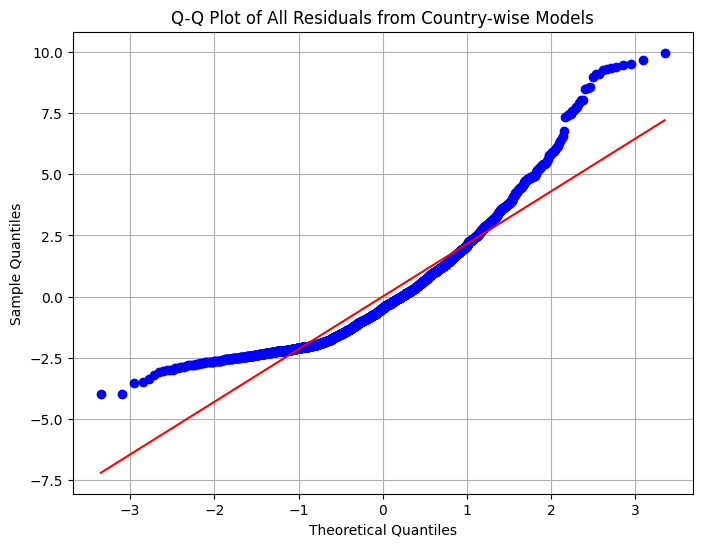

In [11]:
significant_countries = []
non_significant_countries = []
all_residuals = []

for country in participant_countries:
    country_code, p_value, coefficient, residuals = analyze_country_data_only_distance(country)

    all_residuals.extend(residuals)

    if p_value < 0.05 / len(participant_countries):
        significant_countries.append((country_code, p_value, coefficient))
    else:
        non_significant_countries.append((country_code, p_value, coefficient))

significant_countries.sort(key=lambda x: x[1])
non_significant_countries.sort(key=lambda x: x[1])

print(f"\nSignificant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

print(f"\nNon-significant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in non_significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

plt.figure(figsize=(8, 6))
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of All Residuals from Country-wise Models")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.savefig("../plots/linear_regression/qqplot_all_countries_only_distance_jury.png")
plt.show()

The residuals do not follow a normal distribution, which can be problematic for the validity of the linear regression results.

The central part of the graph follows the red line, so the residuals in this region approximately follow a normal distribution.

This pattern is characteristic of a distribution with heavier tails than the normal distribution (e.g., a t-Student distribution, skewed data, or heteroscedasticity).

### Checking heteroscedascity

In [12]:
import statsmodels.stats.diagnostic as smd
smd.het_breuschpagan(all_residuals, X_agg)


(1.192313401299875,
 0.27486341205278086,
 1.1917461900879043,
 0.27513257510276745)

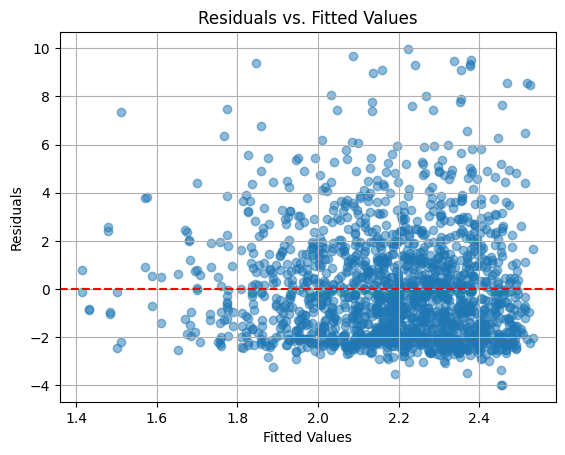

In [13]:
import matplotlib.pyplot as plt

fitted_values = X_agg @ agg_model.params  # Predicted values
plt.scatter(fitted_values, all_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.grid(True)
plt.show()


It does not seems to be heteroscedastic.

# Linear Regression Country-wise using all (not religion) (mean)

In [22]:
def analyze_country_data(country_code):

    country_info_path = "../data/country_info.csv"
    country_info = pd.read_csv(country_info_path)

    country_row = country_info[country_info["code"].str.lower() == country_code.lower()]    # Map the country code to its corresponding country 
    if country_row.empty:
        print(f"Country {country_code} not found in the country information dataset.")
        return
    country_name = country_row["name"].values[0]

    country_data = aggregated_data[aggregated_data["from_country"] == country_code]
    X_full = country_data[["distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]]
    X_agg = sm.add_constant(X_full)
    Y_agg = country_data["jury_points"]

    agg_model = sm.OLS(Y_agg, X_agg).fit()
    agg_summary = agg_model.summary()
    
    p_value = agg_model.pvalues["distance_normalized"]
    coefficient = agg_model.params["distance_normalized"]
    #print(agg_summary)

    return country_name, p_value, coefficient, agg_model.resid


Significant countries (p < 0.0011627906976744186):

Non-significant countries (p < 0.0011627906976744186):
Sweden: p-value = 0.033397 - coefficient = 0.706217
Estonia: p-value = 0.037558 - coefficient = -0.819984
Albania: p-value = 0.043951 - coefficient = -1.104858
Poland: p-value = 0.050846 - coefficient = 0.872139
Belgium: p-value = 0.053317 - coefficient = 0.914571
Montenegro: p-value = 0.060756 - coefficient = -1.036083
Malta: p-value = 0.148088 - coefficient = -0.621027
Latvia: p-value = 0.166601 - coefficient = -0.585040
Italy: p-value = 0.172663 - coefficient = 0.598022
North Macedonia: p-value = 0.242412 - coefficient = -0.436877
Lithuania: p-value = 0.262387 - coefficient = 0.554890
Netherlands: p-value = 0.264862 - coefficient = 0.394321
United Kingdom: p-value = 0.298259 - coefficient = 0.588970
Germany: p-value = 0.306336 - coefficient = 0.491794
Bulgaria: p-value = 0.318415 - coefficient = -0.540823
Israel: p-value = 0.321802 - coefficient = 0.393390
Norway: p-value = 0.

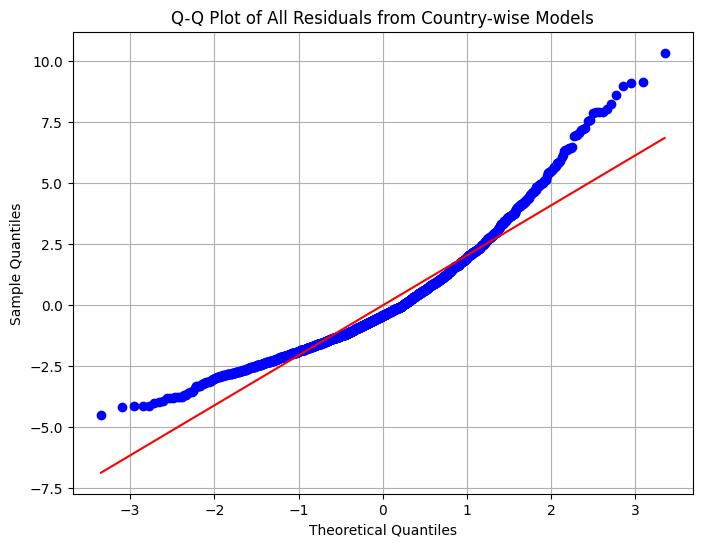

In [23]:
significant_countries = []
non_significant_countries = []
all_residuals = []

for country in participant_countries:
    country_code, p_value, coefficient, residuals = analyze_country_data(country)

    all_residuals.extend(residuals)

    if p_value < 0.05 / len(participant_countries):
        significant_countries.append((country_code, p_value, coefficient))
    else:
        non_significant_countries.append((country_code, p_value, coefficient))

significant_countries.sort(key=lambda x: x[1])
non_significant_countries.sort(key=lambda x: x[1])

print(f"\nSignificant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

print(f"\nNon-significant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in non_significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

plt.figure(figsize=(8, 6))
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of All Residuals from Country-wise Models")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.savefig("../plots/linear_regression/qqplot_all_countries_jury.png")
plt.show()